Test compositional lotka volterra algorithm on human gut time series (female test person).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import torch
from scipy.io import loadmat

# from scipy.special import logsumexp
# from scipy.stats import pearsonr
# from scipy.stats import norm

from compositional_lotka_volterra import *

# Import dataset

### Read data

In [2]:
# path of data file
subject = "donorA"
tax_level = "Phylum"
filename = f"ts_{subject}_rel_counts_{tax_level}Level_most_abundant_only_relevant.csv"
# filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/02-filter_and_group_ts/"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/data/"

# # specify, if not the whole dataset should be used, but only the time points up to max_samples
# max_samples = 100

In [3]:
# function to import the datafile and put it into the right format
def create_data():
    data = np.genfromtxt(f'{filepath}{filename}', delimiter=",")
    usol = data[1:, :]  # removes header
    ts = usol[:, 0]
    data_y = usol[:, 1:]
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    print("The coodinates have shape {}".format(ts.shape))
    print("The data has shape {}".format(data_y.shape)) 
    return [ts], [data_y]

In [4]:
T, Y = create_data()

The coodinates have shape (365,)
The data has shape (365, 10)


In [5]:
U = [ np.zeros((x.shape[0], 1)) for x in Y ]

### Prepare data

In [6]:
# P then does not contain zero values
P = []
Y_pc = []
log_Y = []
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)

In [7]:
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_idx = -1
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)


In [8]:
# get list of taxa (indices) that are not zero in 95% of the samples
taxa_list_mean = np.where(p.mean(axis=0, keepdims = True) < 0.0005)
n_zeros = (p > 1e-5).sum(axis=0, keepdims = True) 
taxa_list_zero = np.where(n_zeros < 0.15*n_samples)

### Plot data

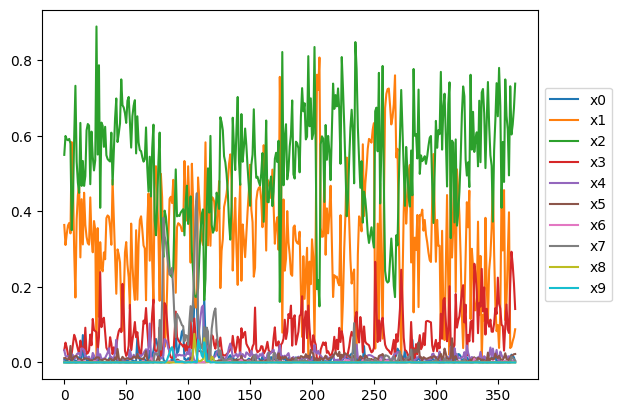

In [9]:
# plot time series over all taxa
fig, ax = plt.subplots()
for i in np.arange(n_taxa):
    ax.plot(T[0], P[0][:,i], label = f"x{i}")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### ALR transformation

In [10]:
print(n_taxa)
print(n_samples)
print(taxa_list_mean[1])
print(len(taxa_list_mean[1]))

10
365
[]
0


In [11]:
choose_denom(P)

2

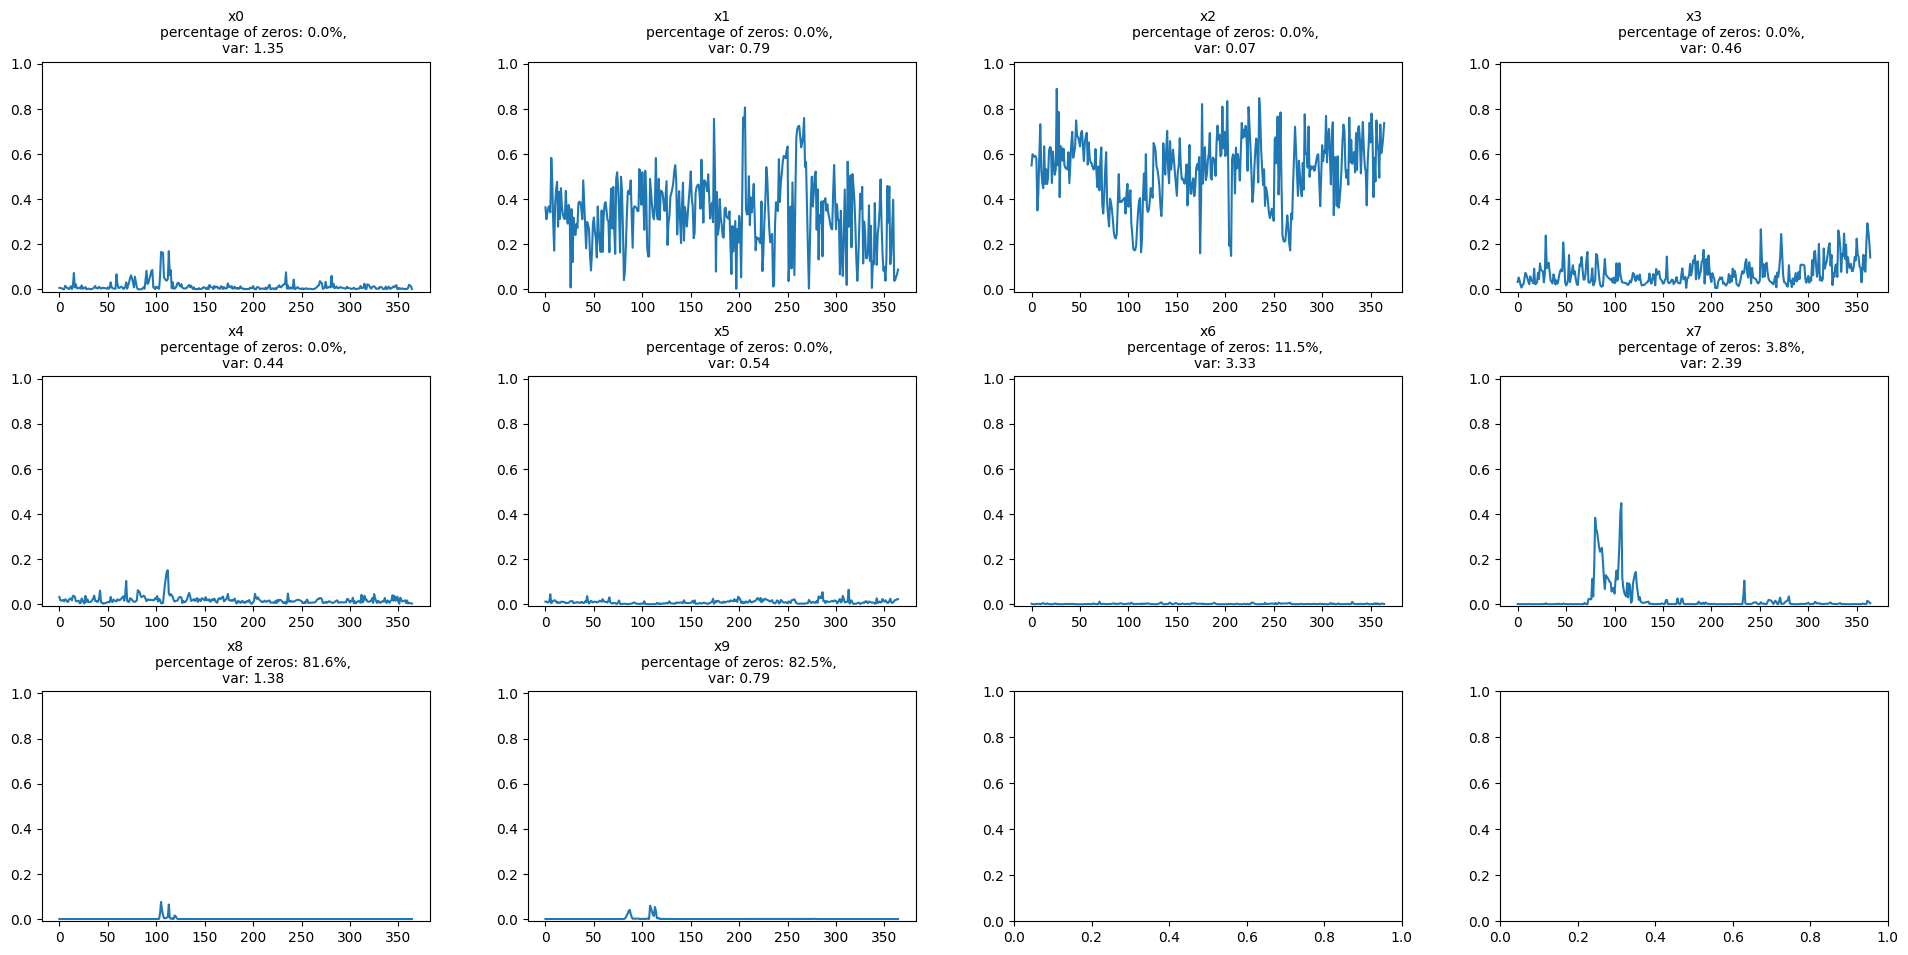

In [13]:
n_row = 3
n_col = 4
fig, axs = plt.subplots(n_row, n_col)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout(pad=4.0)
ind=0
# for i in taxa_list_mean[1]:
for i in np.arange(n_taxa):
    # plot each taxon timeline separately
    axs[math.floor(ind/n_col), (ind%n_col)].plot(T[0], P[0][:,i])
    axs[math.floor(ind/n_col), (ind%n_col)].set_title(f"""x{i}
        percentage of zeros: {round(sum(Y[0][:,i] == 0)/n_samples*100, 1)}%,
        var: {round(vars[i],2)}""")
    axs[math.floor(ind/n_col), (ind%n_col)].title.set_size(10)
    # axs[math.floor(i/n_col), (i%n_col)].set_ylim([-0.01, (max(max(P[0][:,i]), 0.01) + 0.05)])
    axs[math.floor(ind/n_col), (ind%n_col)].set_ylim([-0.01, 1.01])
    ind += 1

### Plot dataset after ALR transformation

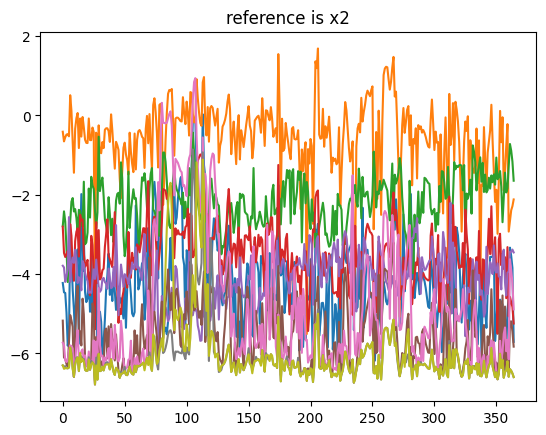

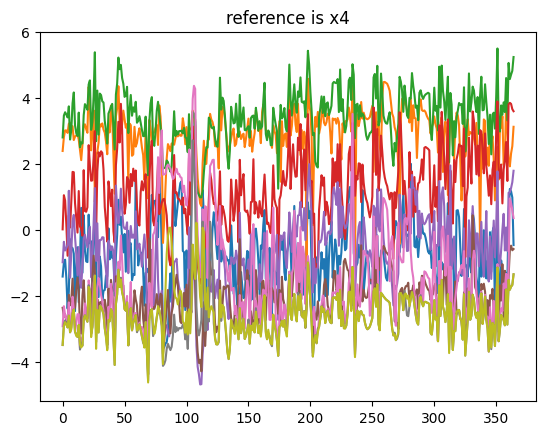

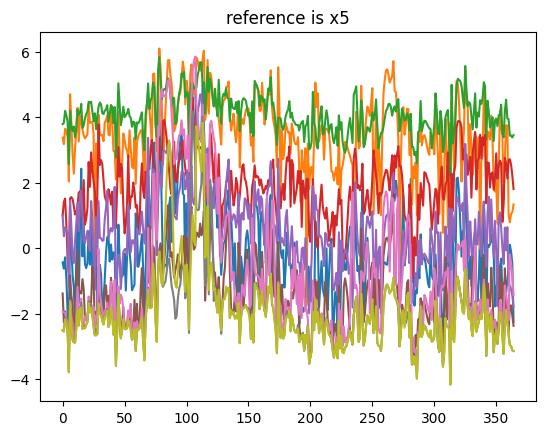

In [67]:
# plot data after alr for transformation with every otu as denominator
for denom_tmp in [2, 4, 5]:
    ALR_tmp = construct_alr(P, denom_tmp)
    # plot alr
    fig, ax = plt.subplots()
    for i in np.arange(n_taxa-1):
        ax.plot(T[0], ALR_tmp[0][:,i]) #, label = f"x{i+1}"
    # ax.plot(T[0], Y[0][:, denom_tmp], color='black', linewidth=2)
    # ax.legend()
    ax.set_title(f"reference is x{denom_tmp}")

### choose final denominator and do alr transformation

4


Text(0.5, 1.0, 'chosen denominator is x4')

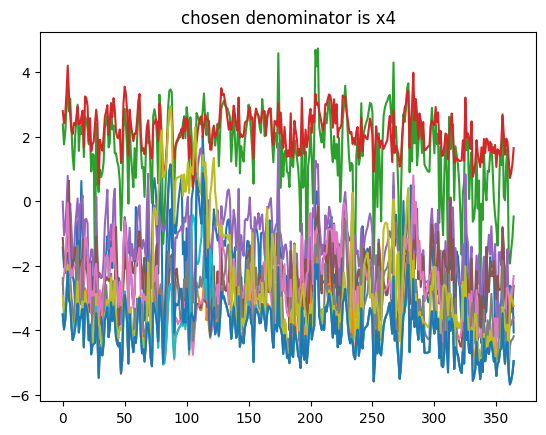

In [51]:
# use choose_denom function to select denominator
# denom = choose_denom(P)
denom = 4
# denom = 5 # or 3 for donorA (PhylumLevel)
# denom = 5 # or 2, 3 for donorB (PhylumLevel)
# denom = 2 # or 4, 5, 0, 1 for female (PhylumLevel)
# denom = 5 # or 2, 0, 1 for male (PhylumLevel)
print(denom)

ALR = construct_alr(P, denom)

# plot alr
fig, ax = plt.subplots()
for i in np.arange(n_taxa-1):
    ax.plot(T[0], ALR[0][:,i]) #, label = f"x{i+1}"
ax.set_title(f"chosen denominator is x{denom}")

### save ALR as csv file

In [68]:
# # lists of possible references:
# if subject == "donorA":
#     ref_list = [5, 3]
# elif subject == "donorB":
#     ref_list = [5, 2, 3]
# elif subject == "female":
#     ref_list = [2, 4, 5, 0, 1]
# elif subject == "male":
#     ref_list = [5, 2, 0, 1]
# else: 
#     ref_list = [choose_denom(P)]

ref_list = [4]

# save alr as csv file
for denom in ref_list:
    ALR = construct_alr(P, denom)
    df_ALR = pd.DataFrame(ALR[0])
    df_ALR.insert(0, "Time", T[0])
    df_ALR.to_csv(f'{filepath}ALR_denom{denom}_{filename}', index=False)

# Compositional Lotka Volterra

In [ ]:
estimate_elastic_net_regularizers_cv(X = ALR, P=P, U=U, T = T, denom = denom, folds = 10)

In [ ]:
clv = CompositionalLotkaVolterra(P, T, pseudo_count=1e-5)
# clv.estimate_ridge_regularizers_cv(ALR, P, U = None, T, 7)

# estimate_elastic_net_regularizers_cv(clv, P, T=T, denom=denom)

In [ ]:
# rs = [0.1, 0.5, 0.7, 0.9, 1]
# alphas = [0.1, 1, 10]

clv.alpha = 1
clv.r_A = 0.5
clv.r_g = 0.5
clv.r_B = 0.5

In [ ]:
clv.train()

In [ ]:
A_clv, g_clv, B_clv = clv.get_params()

In [ ]:
print(A_clv, g_clv, B_clv)